## Text preprocessing
Since, we are interested in topics, we have to find a way to analyze the text.
1. To start with, we have to clean the text from the parts we are not interested in. This includes:
    1. URLs
    2. Punctuation
    3. Stopwords: words which are used a lot, but does not add anything to the semantics of the sentences and useless for our case. Like: 'a', 'the', 'ha'.
    4. Also, we decided to remove numbers, so we analyze only topics part
2. The next part is the lemmatizing the text. Since we are not interested in sentence structures and only in the topics, we can replace the form of the word with its original form. It has two purposes:
    1. Since there might be words in different forms, we will be able to detect them and unite in one topic.
    2. We are not interested in grammatically correct sentences (if we are talking about twitter, we may not have grammatically correct sentences), so, we remove the complication as sentence structure and dependence on it. After that we can work with the text as 'bag of words' 

In [2]:
import pandas as pd
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
warnings.filterwarnings("ignore")
PUNCT_TO_REMOVE = string.punctuation + '\n\t' + '…'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_urls(text):
    return re.sub(r"http\S+", "", text)


In [4]:
tweets = pd.read_csv("../analysis_data/covid19_tweets.csv")
tweets = tweets[['text']]
tweets.text = tweets.text.apply(str)
tweets.text = tweets.text.str.lower()
tweets.text = tweets.text.apply(lambda tweet: remove_urls(tweet))
tweets.text = tweets.text.apply(lambda tweet: remove_punctuation(tweet))
tweets.text = tweets.text.apply(lambda tweet: remove_numbers(tweet))
tweets.text = tweets.text.apply(lambda tweet: lemmatize_words(tweet))
tweets.text = tweets.text.apply(lambda tweet: remove_stopwords(tweet))
tweets.head()

,text
0,smelled scent hand sanitizers today someone pa...
1,hey yankee yankeespr mlb wouldnt made sense pl...
2,diane wdunlap realdonaldtrump trump never clai...
3,brookbanktv one gift covid ha give appreciatio...
4,july medium bulletin novel coronavirusupdates ...


In [5]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
tweet_tok = []
for string in tweets.text:
    tweet_tok.append([el.lower() for el in tokenizer.tokenize(string)])

In [6]:
# get 1000 most frequent words with the length 4 or more
from collections import Counter
cnt = Counter()
for tweet in tweets.text.values:
    for word in tweet.split():
        if len(word) >= 4 and ('’' not in list(word)):
            cnt[word] += 1
        
most_common_words = cnt.most_common(1000)

In [8]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import numpy as np
# applying the clusterization model to detect the main clusters of possible topics 
model =  Word2Vec.load("../word2vec.model")
word_vectors = []
for word in most_common_words[:500]:
    vector = model.wv[str(word[0])]
    word_vectors.append(vector)
word_vectors = np.array(word_vectors)
kmeans = KMeans(n_clusters=5, random_state=0).fit(word_vectors)
labels = kmeans.labels_

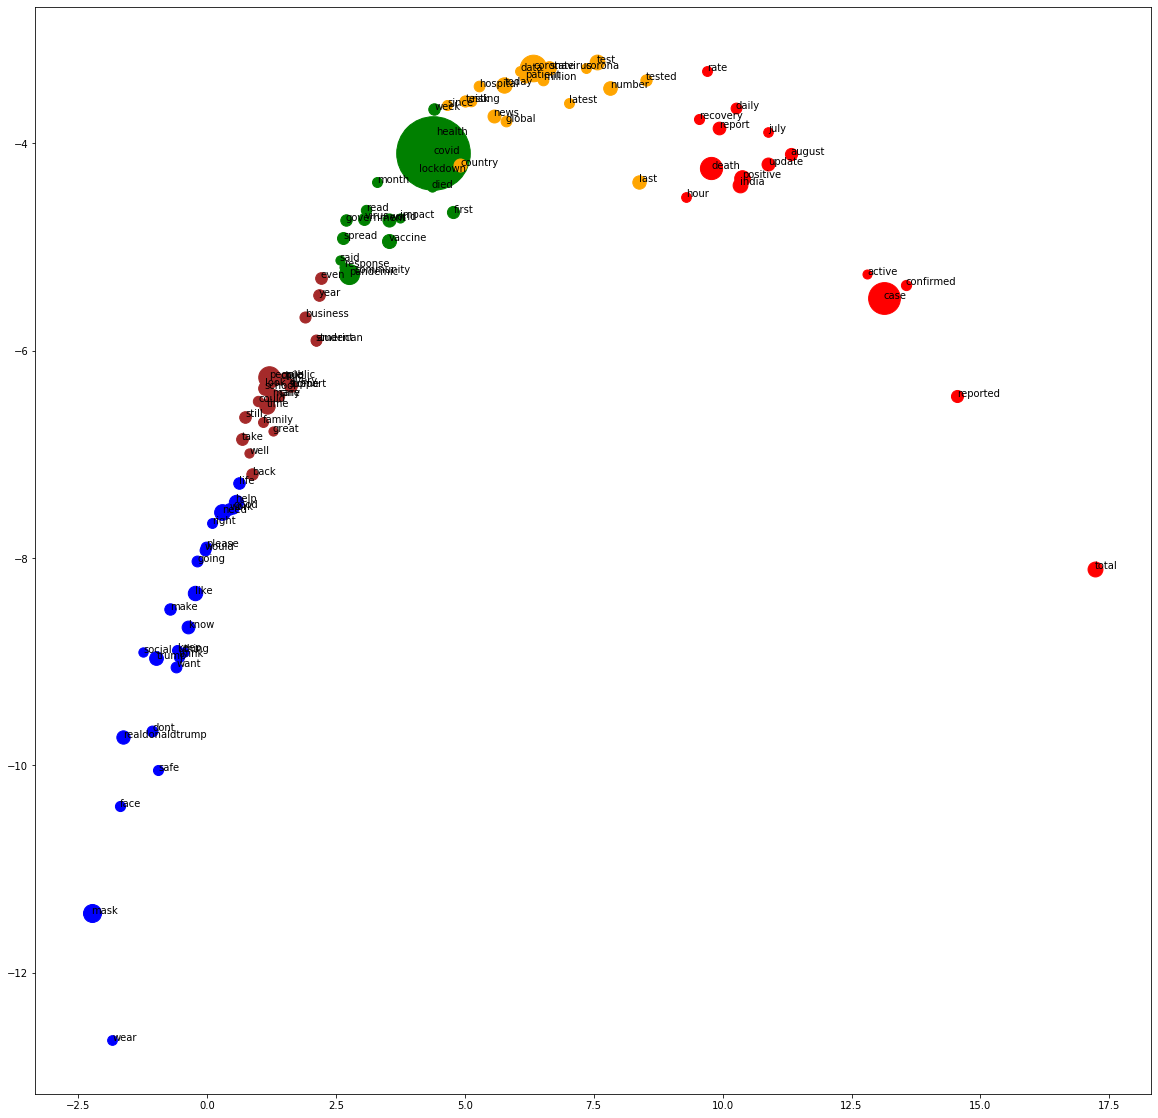

In [9]:
# train word2vec
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
colors = ['red', 'blue', 'green', 'orange', 'brown']
for i in range(100):
    word = most_common_words[i]
    vector = model.wv[str(word[0])]
    plt.scatter([vector[0]], [vector[1]], label=word[0], s=float(word[1])/20., color=colors[labels[i]])
    plt.text(vector[0], vector[1], s=word[0]) 
plt.savefig("covid_img.png")

In [10]:
appearance_matrix = np.genfromtxt('appearance_matrix.csv', delimiter=',', dtype=int)

After that we are interested in finding the threshold to detect if the words should have link between them in graph. For this case we have to normalize the matrix, because:
1. We want to detect how tight the words are connected and for example, we may have the word "covid" which appears, for example, 10000 times and cooccure with the word "Italy" 90. This is not much. But for example "wuhan" appear only 100 times and cooccure with "first" 90 of them, which is pretty strong link.
2. According these matrix we are finding the threshold, which will mean strong connection between words.

In [11]:
# normalization of the matrix to the comfortable range
diagonal = appearance_matrix.diagonal()
division_matrix = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        division_matrix[i, j] = diagonal[min(i, j)]
appearance_matrix  = appearance_matrix.astype(float) / division_matrix.astype(float)

In [12]:
adjacency_matrix = appearance_matrix > 0.02
adjacency_matrix.sum()

9412

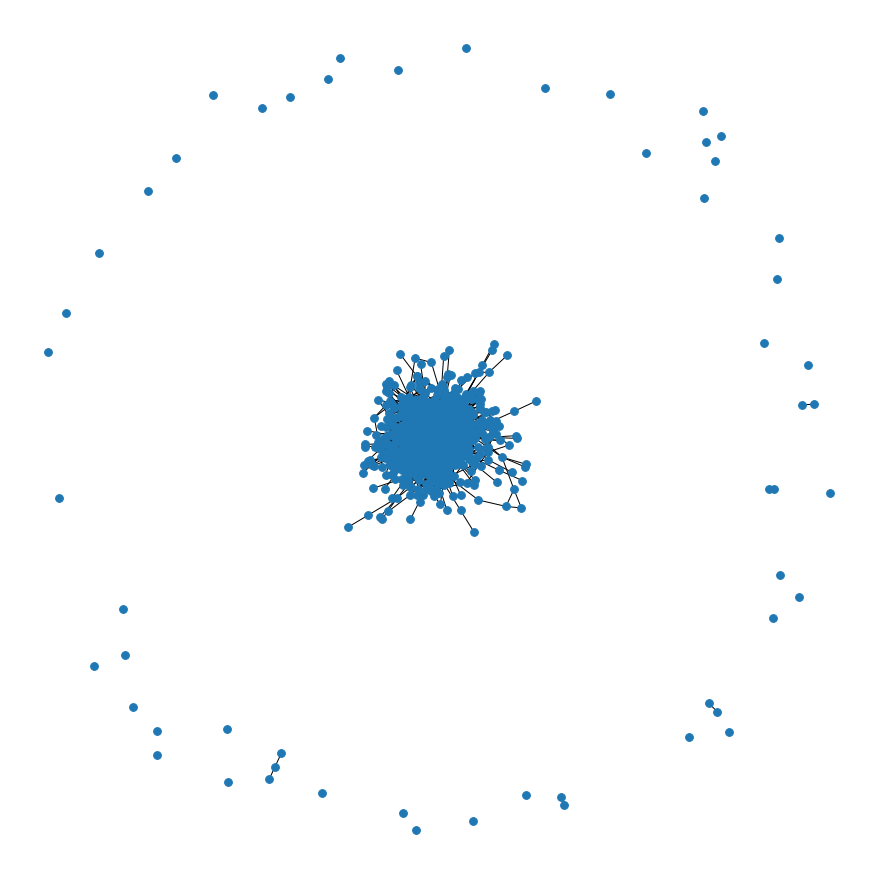

In [113]:
# let's look at the graph of that matrix
import networkx as nx
graph = nx.convert_matrix.from_numpy_matrix(adjacency_matrix)
plt.figure(3,figsize=(12,12)) 
nx.draw(graph, node_size=60,font_size=8)

Another part of out analysis is comparation between tweets and news. Here we apply the same text preprocessing methods for the news datasets. 

In [13]:
a = pd.read_csv("../analysis_data/first_data_covid.csv") # 0 for fake
b = pd.read_excel("../analysis_data/fake_new_dataset.xlsx").drop(columns=['Unnamed: 0', 'subcategory']) #0 for fake
b['headlines'] = b['title'] + ' ' + b['text']
b['outcome'] = b['label']
b = b.drop(columns=['title', 'text', 'label'])
data = pd.concat([a, b])
data['headlines'] = data["headlines"].str.lower()
data['headlines'] = data['headlines'].apply(str)
data["headlines"] = data["headlines"].apply(lambda text: remove_punctuation(text))
data["headlines"] = data["headlines"].apply(lambda text: lemmatize_words(text))
data["headlines"] = data["headlines"].apply(lambda text: remove_stopwords(text))
data.head()

,headlines,outcome
0,post claim compulsory vacination violates prin...,0
1,photo claim person doctor died attending many ...,0
2,post video claim protest confination town aran...,0
3,death respiratory failure pneumonia registered...,0
4,dean college biologist euskadi state lot pcr f...,0


In [14]:
# divide the data into fake and real news
fake = data[data['outcome'] == 1]
real = data[data['outcome'] == 0]
Counter(data['outcome']) #0 for true news, 1 for fake news

Counter({0: 10785, 1: 2535})

In [15]:
# let's define the set of emotional words which we want to analyze
# then for the real news dataset we calculate an appearances of every of them
emo_words = ['good', 'well', 'great', 'best', 'hope', 'love', 'hard', 'relief', 'fear', 'worst']
real_emo_dict = dict(zip(emo_words, list(range(10))))
for text in real["headlines"].values:
    for word in text.split():
        if word in emo_words:
            real_emo_dict[word] += 1
real_emo_dict

{'good': 364,
 'well': 535,
 'great': 170,
 'best': 237,
 'hope': 154,
 'love': 80,
 'hard': 120,
 'relief': 106,
 'fear': 320,
 'worst': 75}

In [16]:
# the same for the tweets
emo_words = ['good', 'well', 'great', 'best', 'hope', 'love', 'hard', 'relief', 'fear', 'worst']
tweet_emo_dict = dict(zip(emo_words, list(range(10))))
for text in tweets["text"].values:
    for word in text.split():
        if word in emo_words:
            tweet_emo_dict[word] += 1
tweet_emo_dict

{'good': 2481,
 'well': 1704,
 'great': 1687,
 'best': 1231,
 'hope': 1075,
 'love': 1045,
 'hard': 739,
 'relief': 685,
 'fear': 655,
 'worst': 523}

In [18]:
# save to the file
real_data = np.array(list(real_emo_dict.values()))
sum_real = real_data.sum() * 0.01
real_data = np.array(real_data//sum_real, dtype=int)
tweet_data = np.array(list(tweet_emo_dict.values()))
sum_tweet = tweet_data.sum() * 0.01
tweet_data = np.array(tweet_data//sum_tweet, dtype=int)

df = pd.DataFrame(list(zip(emo_words, real_data, tweet_data)), 
                  columns=['group', 'value', 'value2'])

df.to_csv('emo_data.csv', index=False)

In [19]:
# the same processing but for the regular covid words
reg_words = ['corona', 'case', 'coronavirus', 'death', 'pandemic', 'mask', 'health', 'positive', 'test', 'vaccine']
tweet_reg_dict = dict(zip(reg_words, list(range(10))))
for text in tweets["text"].values:
    for word in text.split():
        if word in reg_words:
            tweet_reg_dict[word] += 1
tweet_reg_dict

{'corona': 1961,
 'case': 20195,
 'coronavirus': 14186,
 'death': 9852,
 'pandemic': 8075,
 'mask': 6493,
 'health': 5233,
 'positive': 4882,
 'test': 4409,
 'vaccine': 3942}

In [20]:
reg_words = ['covid19', 'case', 'coronavirus', 'death', 'pandemic', 'mask', 'health', 'positive', 'test', 'vaccine']
real_reg_dict = dict(zip(reg_words, list(range(10))))
for text in real["headlines"].values:
    for word in text.split():
        if word in reg_words:
            real_reg_dict[word] += 1
real_reg_dict

{'covid19': 4234,
 'case': 1833,
 'coronavirus': 6007,
 'death': 1068,
 'pandemic': 1067,
 'mask': 841,
 'health': 1993,
 'positive': 440,
 'test': 586,
 'vaccine': 1252}

In [21]:
import numpy as np
real_data = np.array(list(real_reg_dict.values()))
sum_real = real_data.sum() * 0.01
real_data = np.array(real_data//sum_real, dtype=int)
tweet_data = np.array(list(tweet_reg_dict.values()))
sum_tweet = tweet_data.sum() * 0.01
tweet_data = np.array(tweet_data//sum_tweet, dtype=int)

df_reg = pd.DataFrame(list(zip(reg_words, real_data, tweet_data)), 
                  columns=['group', 'value', 'value2'])

df_reg.to_csv('reg_data.csv', index=False)

In [22]:
# the same but for medical terminology words
term_words = ['infection', 'respiratory', 'transmission', 'prevention', 'spreading',
            'clinical', 'influenza', 'antibody', 'pathogen', 'biological']
tweet_term_dict = dict(zip(term_words, list(range(10))))
for text in tweets["text"].values:
    for word in text.split():
        if word in term_words:
            tweet_term_dict[word] += 1
tweet_term_dict

{'infection': 1608,
 'respiratory': 142,
 'transmission': 567,
 'prevention': 271,
 'spreading': 446,
 'clinical': 453,
 'influenza': 87,
 'antibody': 331,
 'pathogen': 31,
 'biological': 51}

In [23]:
real_term_dict = dict(zip(term_words, list(range(15))))
for text in real["headlines"].values:
    for word in text.split():
        if word in term_words:
            real_term_dict[word] += 1
real_term_dict

{'infection': 1049,
 'respiratory': 511,
 'transmission': 207,
 'prevention': 174,
 'spreading': 248,
 'clinical': 226,
 'influenza': 158,
 'antibody': 297,
 'pathogen': 172,
 'biological': 191}

In [24]:
import numpy as np
real_data = np.array(list(real_term_dict.values()))
sum_real = real_data.sum() * 0.01
real_data = np.array(real_data//sum_real, dtype=int)
tweet_data = np.array(list(tweet_term_dict.values()))
sum_tweet = tweet_data.sum() * 0.01
tweet_data = np.array(tweet_data//sum_tweet, dtype=int)

df_term = pd.DataFrame(list(zip(term_words, real_data, tweet_data)), 
                  columns=['group', 'value', 'value2'])

df_term.to_csv('term_data.csv', index=False)

In [29]:
# this is the vizualization of the words for M1, to check what are we are dealing with
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords_ = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

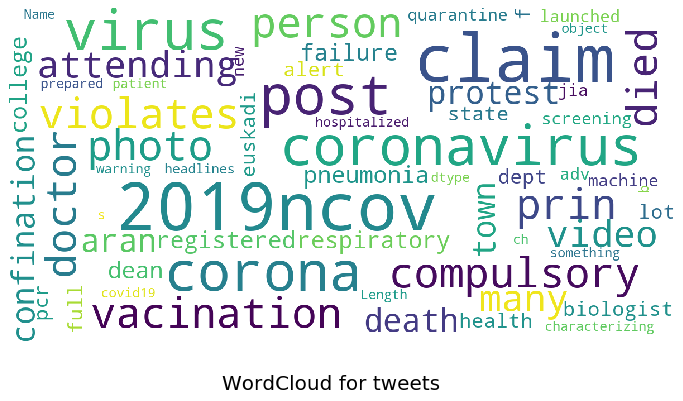

In [30]:
show_wordcloud(data['headlines'], "WordCloud for tweets") #simple visualization for the most common words